# GDSCv2 Analysis - Erlotinib (10 clusters)

This notebook shows a PyMC model that incorporates basket + clustering

In [1]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys

sys.path.append('..')
sys.path.append('.')

In [3]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns
from sklearn.cluster import KMeans

In [4]:
from pyBasket.common import load_obj, save_obj
from pyBasket.model import get_model_pyBasket, get_model_pyBasket_nc
from pyBasket.model import get_model_simple, get_model_bhm_nc, get_model_bhm
from pyBasket.clustering import get_cluster_df_by_basket, plot_PCA, get_patient_df
from pyBasket.preprocessing import select_rf, check_rf, get_pivot_count_df

# Load expression data

In [5]:
data_dir = os.path.abspath(os.path.join('..', 'Data'))
data_dir

'/Users/joewandy/Work/git/pyBasket/Data'

The data consists of 446 samples x 19957 transcripts

In [6]:
expr_file = os.path.join(data_dir, 'GDSCv2.exprsALL.tsv')
df = pd.read_csv(expr_file, sep='\t')
expr_df = df.drop(df.index[-25:]).transpose()
expr_df

,ENSG00000000003.15,ENSG00000000005.6,ENSG00000000419.12,ENSG00000000457.14,ENSG00000000460.17,ENSG00000000938.13,ENSG00000000971.16,ENSG00000001036.14,ENSG00000001084.13,ENSG00000001167.14,...,ENSG00000288436.1,ENSG00000288460.1,ENSG00000288520.1,ENSG00000288529.1,ENSG00000288534.1,ENSG00000288547.1,ENSG00000288550.1,ENSG00000288558.1,ENSG00000288564.1,ENSG00000288570.1
TGBC24TKB,3.842223,-5.465508,6.643472,2.413681,3.523928,-6.722421,1.493328,5.312851,7.657224,4.241038,...,-9.965784,-6.590911,-9.965784,-9.965784,3.498175,-9.965784,-0.647309,1.826165,-5.399761,-9.965784
EGI-1,5.477477,-3.712215,5.685061,3.274900,3.243179,-4.146015,4.508079,4.801951,4.677299,4.812610,...,-5.393783,-6.552767,-4.030988,-9.965784,2.821231,-9.965784,-1.324475,1.050212,-3.380326,-9.965784
TGBC1TKB,5.247886,-5.464387,6.443945,2.174270,4.884496,-3.860326,-2.119720,6.585122,7.530231,4.834777,...,-3.459260,-9.965784,-6.932179,-9.965784,2.675651,-3.173723,-2.442109,1.872312,-2.986262,-9.965784
ETK-1,5.772839,-5.669225,6.345230,2.088130,4.272358,-6.904595,2.426256,6.914759,6.597911,4.163071,...,-3.497535,-6.780472,-3.047387,-9.965784,3.500665,-9.965784,-1.753472,1.533735,-3.042083,-9.965784
SW1710,3.891433,-6.720904,6.461246,2.432792,3.541814,-6.584625,4.976817,5.593969,4.455942,5.065822,...,-2.528606,-5.514698,-4.137394,-9.965784,3.020995,-1.689065,-1.219231,1.743528,-1.304345,-9.965784
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ASH-3,3.230687,-9.965784,6.793055,2.174138,2.815748,-6.168741,3.105009,4.966726,4.675848,4.668331,...,-9.965784,-9.965784,-9.965784,-9.965784,1.998570,-9.965784,-0.486651,0.090239,-1.683468,-9.965784
KMH-2,2.644470,-9.965784,7.369643,2.521319,4.211213,-9.965784,1.926462,5.212597,3.104173,3.763338,...,-6.705062,-9.965784,-1.975997,-9.965784,2.052412,-9.965784,-0.561202,-0.021777,-2.262192,-9.965784
HTC-C3,4.297403,-9.965784,6.790183,1.780538,2.229505,-2.115773,3.557124,4.339450,4.492282,4.175475,...,-9.965784,-6.805531,-9.965784,-9.965784,1.023656,-9.965784,-1.808425,0.997827,-2.137166,-9.965784
IHH-4,2.770616,-5.795143,5.490973,3.801877,4.603189,-2.927377,-3.172772,-0.264386,4.179838,4.530007,...,-2.538738,-5.954484,-9.965784,-9.965784,1.825162,-9.965784,-2.307655,1.466204,-2.971226,-9.965784


Each sample is assigned to one tissue

In [7]:
tissue_df = df.tail(25).astype(int).transpose()
tissue_df

,CNS/Brain,Bone,Prostate,Esophagus/Stomach,Bladder/Urinary Tract,Ovary/Fallopian Tube,Lymphoid,Kidney,Thyroid,Soft Tissue,...,Uterus,Pancreas,Breast,Cervix,Bowel,Peripheral Nervous System,Liver,Biliary Tract,Other,Ampulla of Vater
TGBC24TKB,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
EGI-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
TGBC1TKB,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
ETK-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
SW1710,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ASH-3,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
KMH-2,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
HTC-C3,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
IHH-4,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
flat_list = tissue_df.reset_index().melt(id_vars='index', var_name='tissue', value_name='belongs_to_tissue')
flat_list = flat_list[flat_list['belongs_to_tissue'] != 0]

# set the index to the sample name
flat_list = flat_list.set_index('index')

# create the dictionary
sample_dict = flat_list['tissue'].to_dict()

In [9]:
tissues = np.array([sample_dict[s] for s in expr_df.index.values])
tissues[0:10]

array(['Biliary Tract', 'Biliary Tract', 'Biliary Tract', 'Biliary Tract',
       'Bladder/Urinary Tract', 'Bladder/Urinary Tract',
       'Bladder/Urinary Tract', 'Bladder/Urinary Tract',
       'Bladder/Urinary Tract', 'Bone'], dtype='<U25')

# Do PCA and colour by basket (tissues)

PCA explained variance [0.12949628 0.22238095 0.28729125 0.32075101 0.34293046 0.36347672
 0.38132787 0.39535598 0.40877652 0.42098266]


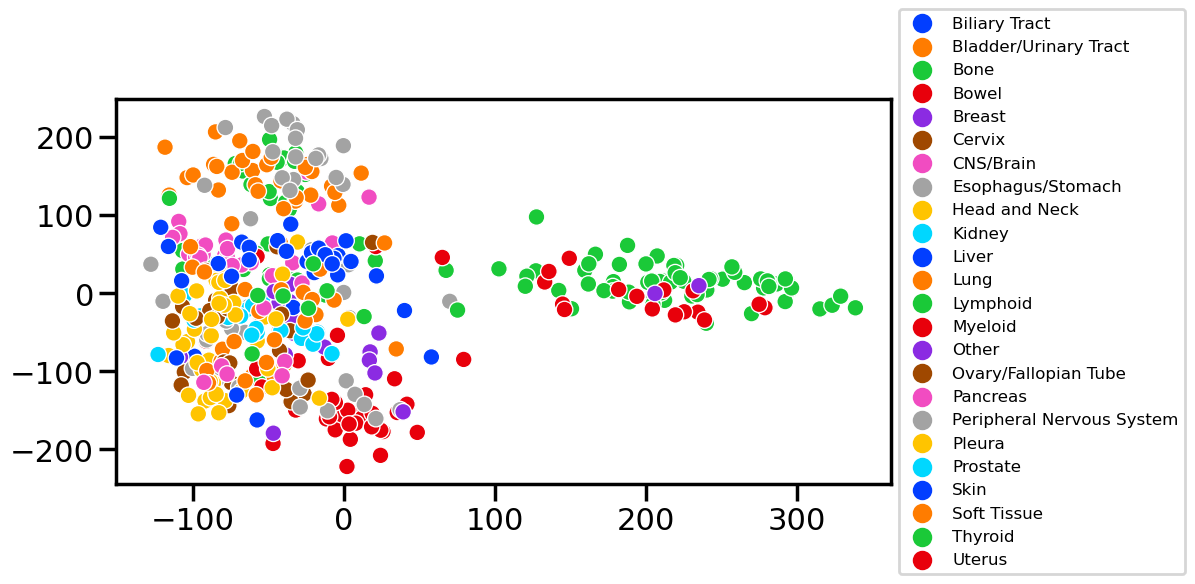

In [10]:
_ = plot_PCA(expr_df, n_components=10, hue=tissues)

# Load drug responses data

Each sample also has its corresponding drug response. There are 11 drugs.

In [11]:
response_file = os.path.join(data_dir, 'GDSCv2.aacALL.tsv')
response_df = pd.read_csv(response_file, sep='\t').transpose()
response_df

,Bortezomib,Entinostat,Sirolimus,Docetaxel,Gemcitabine,Crizotinib,Lapatinib,Vorinostat,Erlotinib,Paclitaxel,Pictilisib
143B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
201T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22Rv1,0.184836,0.142503,0.304184,0.111977,0.596289,0.077036,0.048663,0.240865,0.069736,0.015539,0.254125
23132/87,0.228235,0.121580,0.208475,0.232821,0.407328,0.018921,0.172438,0.235145,0.124366,0.025982,0.431203
380,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
YH-13,0.174638,0.019992,0.157624,0.211467,0.359880,0.008977,0.069979,0.144077,0.108331,0.087400,0.349741
YKG-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
YMB-1-E,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
YT,0.230123,NaN,0.212004,0.113564,0.666782,NaN,0.084477,0.235547,0.000000,0.000000,0.172903


In [12]:
response_df.loc['TGBC24TKB']

Bortezomib     0.046804
Entinostat     0.074151
Sirolimus      0.015096
Docetaxel      0.229496
Gemcitabine    0.410541
Crizotinib     0.000000
Lapatinib      0.239909
Vorinostat     0.181613
Erlotinib      0.128392
Paclitaxel     0.014104
Pictilisib     0.387379
Name: TGBC24TKB, dtype: float64

## Collect the samples and responses for the drug

In [13]:
drug_name = 'Erlotinib'

In [14]:
samples = tissue_df.index.values
response_dict = response_df[drug_name].to_dict()
responses = np.array([response_dict[s] for s in samples])
len(samples), len(responses), len(tissues)

(446, 446, 446)

In [15]:
df = pd.DataFrame({
    'tissues': tissues,
    'samples': samples,    
    'responses': responses
})
df

,tissues,samples,responses
0,Biliary Tract,TGBC24TKB,0.128392
1,Biliary Tract,EGI-1,0.057719
2,Biliary Tract,TGBC1TKB,0.051036
3,Biliary Tract,ETK-1,0.096227
4,Bladder/Urinary Tract,SW1710,0.071891
...,...,...,...
441,Thyroid,ASH-3,0.082204
442,Thyroid,KMH-2,NaN
443,Thyroid,HTC-C3,0.078680
444,Thyroid,IHH-4,0.020141


## Drop all the NaN responses

In [16]:
df = df.dropna(subset=['responses'])
df

,tissues,samples,responses
0,Biliary Tract,TGBC24TKB,0.128392
1,Biliary Tract,EGI-1,0.057719
2,Biliary Tract,TGBC1TKB,0.051036
3,Biliary Tract,ETK-1,0.096227
4,Bladder/Urinary Tract,SW1710,0.071891
...,...,...,...
440,Thyroid,WRO,0.018343
441,Thyroid,ASH-3,0.082204
443,Thyroid,HTC-C3,0.078680
444,Thyroid,IHH-4,0.020141


In [17]:
df['tissues'].unique()

array(['Biliary Tract', 'Bladder/Urinary Tract', 'Bone', 'Bowel',
       'Breast', 'Cervix', 'CNS/Brain', 'Esophagus/Stomach',
       'Head and Neck', 'Kidney', 'Liver', 'Lung', 'Lymphoid', 'Myeloid',
       'Other', 'Ovary/Fallopian Tube', 'Pancreas',
       'Peripheral Nervous System', 'Pleura', 'Prostate', 'Skin',
       'Soft Tissue', 'Thyroid', 'Uterus'], dtype=object)

In [18]:
df.groupby('tissues').count()

,samples,responses
tissues,,
Biliary Tract,4,4
Bladder/Urinary Tract,5,5
Bone,25,25
Bowel,28,28
Breast,10,10
CNS/Brain,14,14
Cervix,13,13
Esophagus/Stomach,19,19
Head and Neck,16,16


In [19]:
df['responses'].max(), df['responses'].min()

(0.352487709036072, 0.0)

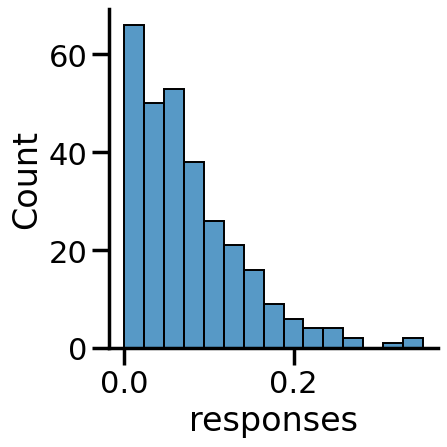

In [20]:
sns.displot(df['responses'])

In [21]:
df['responses'].mean(), df['responses'].median()

(0.07533823628570624, 0.06098308922444)

# Select baskets for analysis

Select some baskets

In [22]:
# basket_names = [
#     'Lymphoid',
#     'Bowel',
#     'Bone',
#     'Lung',
#     'Esophagus/Stomach'
# ]

Use all baskets

In [23]:
basket_names = df['tissues'].unique()
basket_names

array(['Biliary Tract', 'Bladder/Urinary Tract', 'Bone', 'Bowel',
       'Breast', 'Cervix', 'CNS/Brain', 'Esophagus/Stomach',
       'Head and Neck', 'Kidney', 'Liver', 'Lung', 'Lymphoid', 'Myeloid',
       'Other', 'Ovary/Fallopian Tube', 'Pancreas',
       'Peripheral Nervous System', 'Pleura', 'Prostate', 'Skin',
       'Soft Tissue', 'Thyroid', 'Uterus'], dtype=object)

In [24]:
df_filtered = df[df['tissues'].isin(basket_names)].reset_index(drop=True)
df_filtered

,tissues,samples,responses
0,Biliary Tract,TGBC24TKB,0.128392
1,Biliary Tract,EGI-1,0.057719
2,Biliary Tract,TGBC1TKB,0.051036
3,Biliary Tract,ETK-1,0.096227
4,Bladder/Urinary Tract,SW1710,0.071891
...,...,...,...
293,Thyroid,WRO,0.018343
294,Thyroid,ASH-3,0.082204
295,Thyroid,HTC-C3,0.078680
296,Thyroid,IHH-4,0.020141


In [25]:
sample_list = df_filtered['samples'].tolist()
expr_df_filtered = expr_df[expr_df.index.isin(sample_list)]
expr_df_filtered.shape, expr_df.shape

((298, 19957), (446, 19957))

In [26]:
expr_df_filtered

,ENSG00000000003.15,ENSG00000000005.6,ENSG00000000419.12,ENSG00000000457.14,ENSG00000000460.17,ENSG00000000938.13,ENSG00000000971.16,ENSG00000001036.14,ENSG00000001084.13,ENSG00000001167.14,...,ENSG00000288436.1,ENSG00000288460.1,ENSG00000288520.1,ENSG00000288529.1,ENSG00000288534.1,ENSG00000288547.1,ENSG00000288550.1,ENSG00000288558.1,ENSG00000288564.1,ENSG00000288570.1
TGBC24TKB,3.842223,-5.465508,6.643472,2.413681,3.523928,-6.722421,1.493328,5.312851,7.657224,4.241038,...,-9.965784,-6.590911,-9.965784,-9.965784,3.498175,-9.965784,-0.647309,1.826165,-5.399761,-9.965784
EGI-1,5.477477,-3.712215,5.685061,3.274900,3.243179,-4.146015,4.508079,4.801951,4.677299,4.812610,...,-5.393783,-6.552767,-4.030988,-9.965784,2.821231,-9.965784,-1.324475,1.050212,-3.380326,-9.965784
TGBC1TKB,5.247886,-5.464387,6.443945,2.174270,4.884496,-3.860326,-2.119720,6.585122,7.530231,4.834777,...,-3.459260,-9.965784,-6.932179,-9.965784,2.675651,-3.173723,-2.442109,1.872312,-2.986262,-9.965784
ETK-1,5.772839,-5.669225,6.345230,2.088130,4.272358,-6.904595,2.426256,6.914759,6.597911,4.163071,...,-3.497535,-6.780472,-3.047387,-9.965784,3.500665,-9.965784,-1.753472,1.533735,-3.042083,-9.965784
SW1710,3.891433,-6.720904,6.461246,2.432792,3.541814,-6.584625,4.976817,5.593969,4.455942,5.065822,...,-2.528606,-5.514698,-4.137394,-9.965784,3.020995,-1.689065,-1.219231,1.743528,-1.304345,-9.965784
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WRO,3.205753,-9.965784,7.307272,-0.607968,0.481533,-9.965784,0.725387,5.847553,4.118905,4.821918,...,-6.475129,-6.749269,-9.965784,-9.965784,2.933364,-9.965784,-2.224737,-1.366209,-1.616199,-9.965784
ASH-3,3.230687,-9.965784,6.793055,2.174138,2.815748,-6.168741,3.105009,4.966726,4.675848,4.668331,...,-9.965784,-9.965784,-9.965784,-9.965784,1.998570,-9.965784,-0.486651,0.090239,-1.683468,-9.965784
HTC-C3,4.297403,-9.965784,6.790183,1.780538,2.229505,-2.115773,3.557124,4.339450,4.492282,4.175475,...,-9.965784,-6.805531,-9.965784,-9.965784,1.023656,-9.965784,-1.808425,0.997827,-2.137166,-9.965784
IHH-4,2.770616,-5.795143,5.490973,3.801877,4.603189,-2.927377,-3.172772,-0.264386,4.179838,4.530007,...,-2.538738,-5.954484,-9.965784,-9.965784,1.825162,-9.965784,-2.307655,1.466204,-2.971226,-9.965784


In [27]:
drug_response = df_filtered.set_index('samples').drop(columns=['tissues'])
drug_response

,responses
samples,
TGBC24TKB,0.128392
EGI-1,0.057719
TGBC1TKB,0.051036
ETK-1,0.096227
SW1710,0.071891
...,...
WRO,0.018343
ASH-3,0.082204
HTC-C3,0.078680


## Feature selection using random forest

In [28]:
try: # try to load previously selected features
    fname = os.path.join('results', '%s_expr_df_selected.p' % drug_name)
    expr_df_selected = load_obj(fname)
    
except FileNotFoundError: # if not found, then re-run feature selection
    expr_df_selected = select_rf(expr_df_filtered, drug_response, n_splits=5, percentile_threshold=90, top_genes=500)
    save_obj(expr_df_selected, fname)

In [29]:
importance_df = check_rf(expr_df_selected, drug_response, test_size=0.2)

Test set results using selected features:
MSE: 0.0032920842730129398
R^2: 0.20947838405718378


In [30]:
expr_df_selected

,ENSG00000090621.14,ENSG00000132517.15,ENSG00000146648.18,ENSG00000149043.16,ENSG00000152894.14,ENSG00000163347.6,ENSG00000168143.9,ENSG00000180638.17,ENSG00000198888.2,ENSG00000205420.11,...,ENSG00000116752.6,ENSG00000116791.14,ENSG00000116906.13,ENSG00000117280.13,ENSG00000117385.16,ENSG00000117560.8,ENSG00000118096.8,ENSG00000118292.9,ENSG00000118705.17,ENSG00000118785.14
TGBC24TKB,6.381521,-1.739429,3.321716,-0.004531,4.734547,5.931521,3.111430,1.966194,13.627491,2.205512,...,5.162435,5.147299,5.606865,2.998651,2.689027,-4.084599,1.582791,-2.710111,7.812905,5.147392
EGI-1,7.610135,-0.751374,5.163625,1.493216,4.720908,6.417578,3.203289,-1.841590,13.199545,-1.218443,...,4.925232,5.226792,5.603523,2.670388,3.690611,-3.501878,3.994157,2.254687,7.025284,-4.545513
TGBC1TKB,6.751622,-1.513449,5.945249,0.627148,5.272171,4.621619,2.635736,-1.039889,12.951333,7.054224,...,6.148827,5.062208,5.476686,3.565310,2.989053,-3.608304,2.541695,-0.928687,7.818634,4.432519
ETK-1,7.070839,0.127958,5.787218,-0.107128,6.046211,5.308687,2.477480,-1.037587,12.310494,0.961998,...,5.247601,4.840509,6.286441,3.783611,4.020878,-4.522908,3.410838,0.532800,8.133642,9.654010
SW1710,7.775491,-2.199953,5.858155,-2.758373,5.425618,4.544722,-4.269562,-0.381611,12.271514,-6.245291,...,5.025107,7.285653,5.875248,4.852093,6.105435,-4.621762,3.015028,0.782099,7.713363,9.941758
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WRO,7.837784,-1.353844,3.763408,-6.732831,5.742105,4.760012,-2.607410,-2.643596,10.482648,-5.459191,...,5.281934,5.111793,4.432248,2.312542,5.967269,-4.153537,2.695865,0.825085,6.924745,4.096984
ASH-3,7.723500,-2.473594,5.331743,-6.200127,4.661784,1.397889,-3.950847,-3.144996,12.233519,-5.668614,...,5.997219,5.313866,4.264601,3.448109,6.406388,-4.216887,4.299667,1.986339,7.446398,1.274876
HTC-C3,6.924446,-0.875604,5.030717,-4.996494,6.072599,9.227226,0.302072,-2.257324,12.757065,-3.826678,...,5.712599,5.132686,5.115367,4.164872,4.130017,-4.510880,5.400644,0.639323,7.529029,1.770304
IHH-4,6.970922,-1.798209,5.552850,-5.065087,3.918782,3.639364,-3.606497,-2.172558,13.085928,-9.965784,...,4.845341,4.250295,5.615404,4.699264,4.436642,-4.521843,3.689322,1.936225,6.832362,0.901152


## Do PCA again on these samples

Before feature selection (using all 19957 transcripts)

PCA explained variance [0.13829637 0.22985784 0.29027512 0.32311007 0.34617996 0.36607902
 0.38141868 0.39592651 0.40932301 0.42133921]


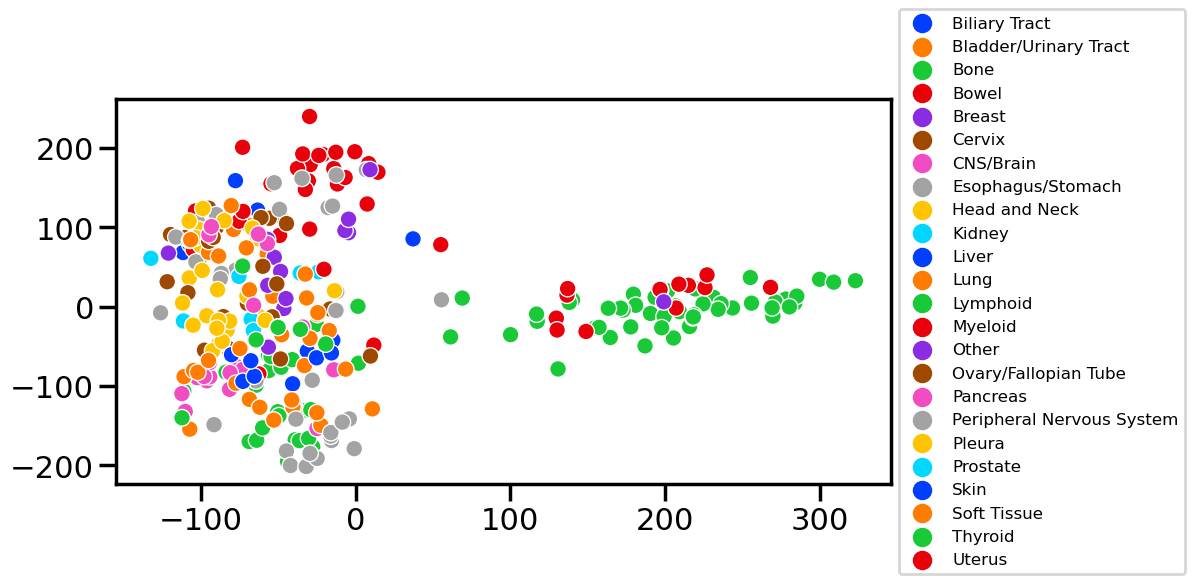

In [31]:
pc1, pc2 = plot_PCA(expr_df_filtered, n_components=10, hue=df_filtered['tissues'].values)

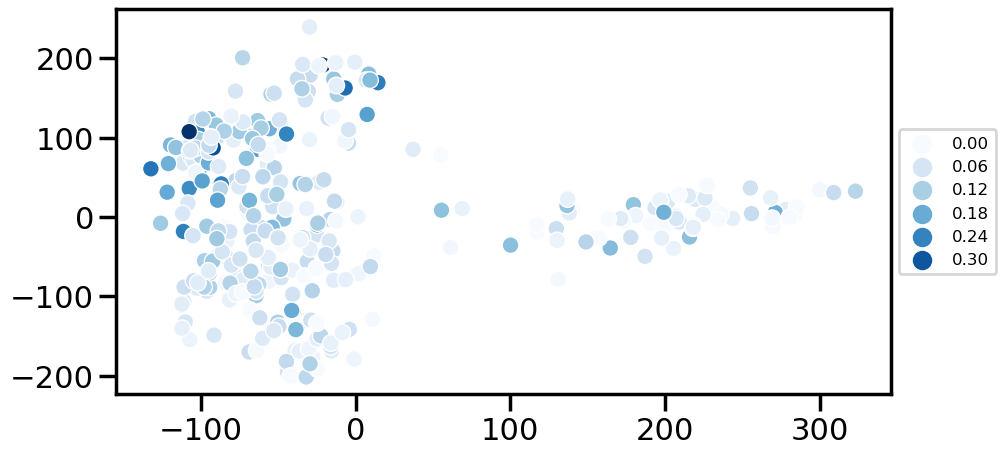

In [32]:
plt.figure(figsize=(10, 5))
g = sns.scatterplot(x=pc1, y=pc2, hue=df_filtered['responses'].values, palette='Blues')
g.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1, fontsize=12)

After feature selection (using 500 transcripts)

PCA explained variance [0.2443426  0.31842748 0.37138039 0.41483141 0.43467953 0.45420608
 0.47068115 0.48621428 0.5008843  0.51525205]


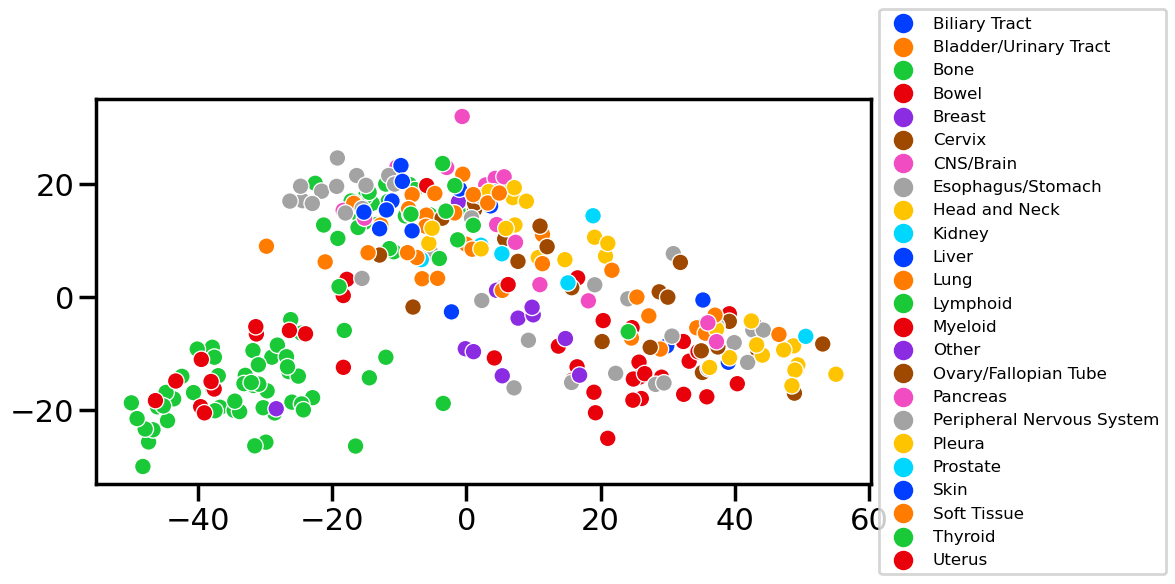

In [33]:
pc1, pc2 = plot_PCA(expr_df_selected, n_components=10, hue=df_filtered['tissues'].values)

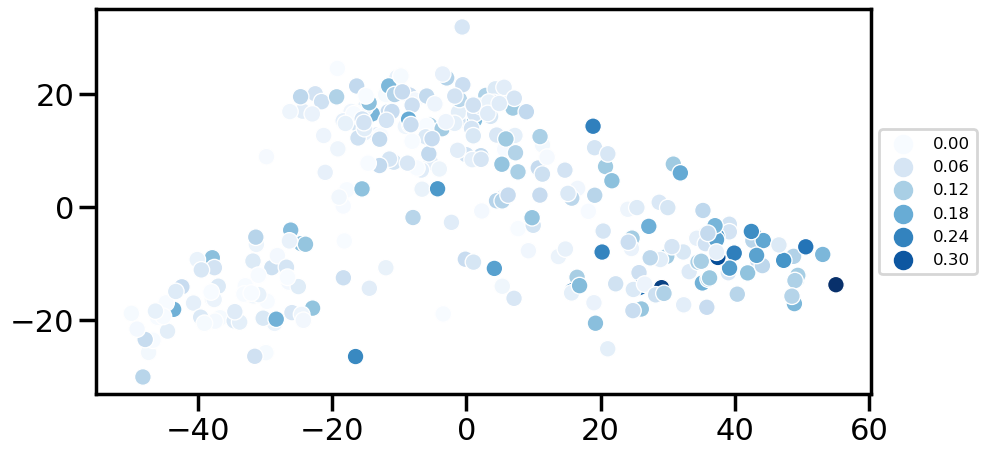

In [34]:
plt.figure(figsize=(10, 5))
g = sns.scatterplot(x=pc1, y=pc2, hue=df_filtered['responses'].values, palette='Blues')
g.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1, fontsize=12)

# Try clustering

In [35]:
expr_df_selected.shape

(298, 500)

In [36]:
classes = df_filtered.set_index('samples')
classes

,tissues,responses
samples,,
TGBC24TKB,Biliary Tract,0.128392
EGI-1,Biliary Tract,0.057719
TGBC1TKB,Biliary Tract,0.051036
ETK-1,Biliary Tract,0.096227
SW1710,Bladder/Urinary Tract,0.071891
...,...,...
WRO,Thyroid,0.018343
ASH-3,Thyroid,0.082204
HTC-C3,Thyroid,0.078680


In [37]:
C = 10

In [38]:
kmeans = KMeans(n_clusters=C, random_state=42)
kmeans.fit(expr_df_selected)

cluster_labels = kmeans.labels_
cluster_labels

array([4, 4, 0, 4, 2, 0, 2, 0, 0, 1, 6, 6, 2, 6, 6, 6, 6, 6, 2, 6, 6, 1,
       1, 6, 1, 2, 6, 1, 6, 6, 2, 6, 6, 2, 4, 7, 4, 7, 4, 4, 4, 4, 0, 4,
       4, 4, 4, 4, 1, 4, 4, 4, 2, 9, 4, 4, 4, 4, 4, 4, 4, 4, 7, 7, 7, 7,
       7, 7, 7, 7, 0, 7, 4, 0, 0, 0, 9, 0, 2, 7, 0, 0, 7, 1, 0, 2, 1, 2,
       6, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 4, 4, 0, 0, 7, 4, 4, 0, 4, 4,
       4, 0, 0, 4, 0, 1, 4, 4, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 2, 2, 2, 2, 2, 2, 1, 1, 1, 5, 0, 5, 4, 9, 4, 9, 9, 9, 1, 9, 4,
       0, 9, 4, 1, 9, 9, 9, 7, 5, 9, 9, 8, 8, 8, 3, 8, 3, 3, 3, 3, 8, 8,
       8, 3, 8, 3, 8, 8, 8, 8, 8, 8, 3, 8, 3, 8, 3, 8, 3, 3, 8, 3, 8, 8,
       3, 3, 3, 8, 3, 3, 3, 8, 8, 8, 8, 3, 3, 3, 1, 8, 3, 3, 3, 3, 8, 3,
       8, 8, 8, 8, 3, 8, 8, 3, 8, 8, 2, 4, 3, 4, 4, 2, 2, 4, 2, 1, 4, 2,
       0, 7, 2, 4, 2, 0, 5, 5, 5, 5, 5, 5, 5, 5, 1, 5, 5, 5, 1, 5, 5, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 7, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2,
       5, 2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2], dtype=i

PCA explained variance [0.2443426  0.31842748 0.37138039 0.41483141 0.43467953 0.45420608
 0.47068115 0.48621428 0.5008843  0.51525205]


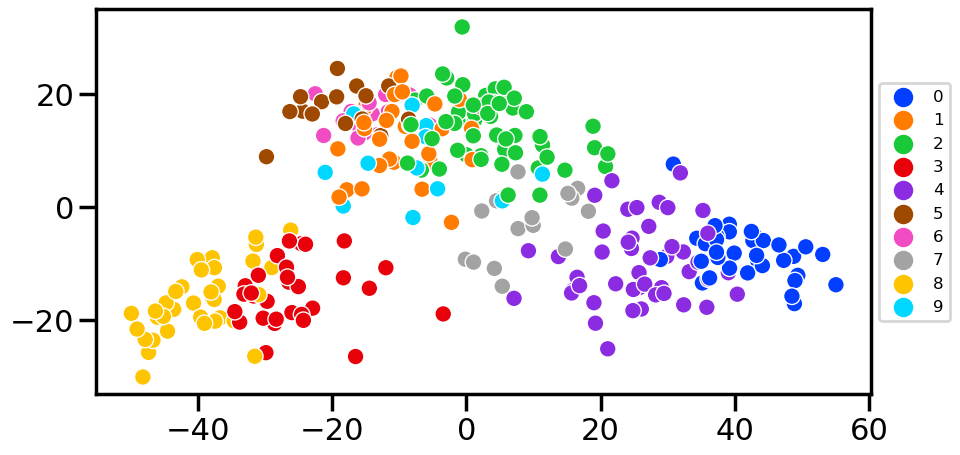

In [39]:
_ = plot_PCA(expr_df_selected, n_components=10, hue=cluster_labels)

# Run basket trial analysis

In [40]:
basket_names

array(['Biliary Tract', 'Bladder/Urinary Tract', 'Bone', 'Bowel',
       'Breast', 'Cervix', 'CNS/Brain', 'Esophagus/Stomach',
       'Head and Neck', 'Kidney', 'Liver', 'Lung', 'Lymphoid', 'Myeloid',
       'Other', 'Ovary/Fallopian Tube', 'Pancreas',
       'Peripheral Nervous System', 'Pleura', 'Prostate', 'Skin',
       'Soft Tissue', 'Thyroid', 'Uterus'], dtype=object)

In [41]:
K = len(basket_names)
K, C

(24, 10)

Create clustering dataframe

In [42]:
class_labels = classes.tissues.values
len(class_labels), len(cluster_labels)

(298, 298)

In [43]:
cluster_df = get_cluster_df_by_basket(class_labels, cluster_labels, normalise=False)
cluster_df

,sk_0,sk_1,sk_2,sk_3,sk_4,sk_5,sk_6,sk_7,sk_8,sk_9
Biliary Tract,1,0,0,0,3,0,0,0,0,0
Bladder/Urinary Tract,3,0,2,0,0,0,0,0,0,0
Bone,0,5,5,0,0,0,15,0,0,0
Bowel,1,1,1,0,22,0,0,2,0,1
Breast,1,0,0,0,0,0,0,9,0,0
CNS/Brain,0,2,11,0,0,0,1,0,0,0
Cervix,7,1,1,0,1,0,0,2,0,1
Esophagus/Stomach,6,2,0,0,10,0,0,1,0,0
Head and Neck,12,1,3,0,0,0,0,0,0,0
Kidney,0,0,5,0,0,0,0,0,0,0


<AxesSubplot: >

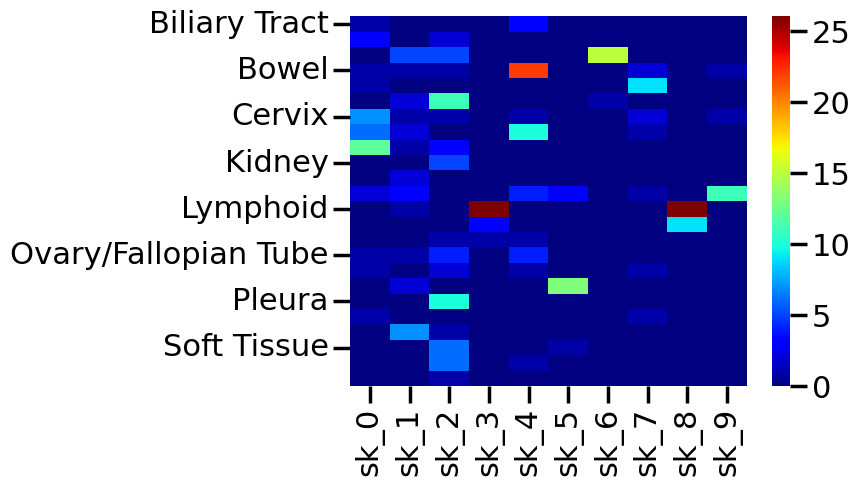

In [44]:
sns.heatmap(cluster_df, cmap='jet')

## Prepare patient data

In [45]:
patient_df = get_patient_df(df_filtered, cluster_labels)

In [46]:
patient_df

,tissues,responses,basket_number,cluster_number,responsive
samples,,,,,
TGBC24TKB,Biliary Tract,0.128392,0,4,0
EGI-1,Biliary Tract,0.057719,0,4,1
TGBC1TKB,Biliary Tract,0.051036,0,0,1
ETK-1,Biliary Tract,0.096227,0,4,0
SW1710,Bladder/Urinary Tract,0.071891,1,2,0
...,...,...,...,...,...
WRO,Thyroid,0.018343,22,2,1
ASH-3,Thyroid,0.082204,22,2,0
HTC-C3,Thyroid,0.078680,22,4,0


In [47]:
pivot_df = get_pivot_count_df(patient_df)
pivot_df

,n_success,n_trial
basket_number,,
0,2,4
1,3,5
2,13,25
3,11,28
4,4,10
5,1,13
6,9,14
7,7,19
8,0,16


## Define models

No. of samples to collect before and after burn-in during MCMC.

In [48]:
n_burn_in = int(5E3)
n_sample = int(5E3)
target_accept = 0.99

### Simple model

In [49]:
model_s = get_model_simple(pivot_df)

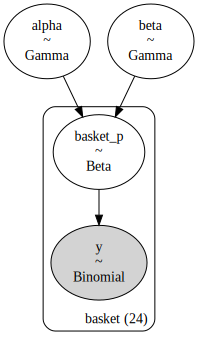

In [50]:
pm.model_to_graphviz(model_s)

In [51]:
with model_s:
    trace_s = pm.sample(n_sample, tune=n_burn_in, idata_kwargs={'log_likelihood': True}, target_accept=target_accept)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, basket_p]


Sampling 4 chains for 5_000 tune and 5_000 draw iterations (20_000 + 20_000 draws total) took 75 seconds.


In [52]:
az.summary(trace_s).round(2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,2.11,0.72,0.93,3.48,0.01,0.0,9850.0,11992.0,1.0
beta,2.53,0.84,1.10,4.11,0.01,0.0,11334.0,12991.0,1.0
basket_p[0],0.48,0.16,0.17,0.77,0.00,0.0,36217.0,13556.0,1.0
basket_p[1],0.53,0.16,0.23,0.82,0.00,0.0,33183.0,13276.0,1.0
basket_p[2],0.51,0.09,0.34,0.68,0.00,0.0,36344.0,14642.0,1.0
basket_p[3],0.40,0.08,0.24,0.56,0.00,0.0,40542.0,14864.0,1.0
basket_p[4],0.42,0.12,0.20,0.66,0.00,0.0,36596.0,14087.0,1.0
basket_p[5],0.18,0.09,0.02,0.35,0.00,0.0,27458.0,12332.0,1.0
basket_p[6],0.60,0.11,0.39,0.81,0.00,0.0,37892.0,12850.0,1.0
basket_p[7],0.38,0.10,0.20,0.57,0.00,0.0,38862.0,14229.0,1.0


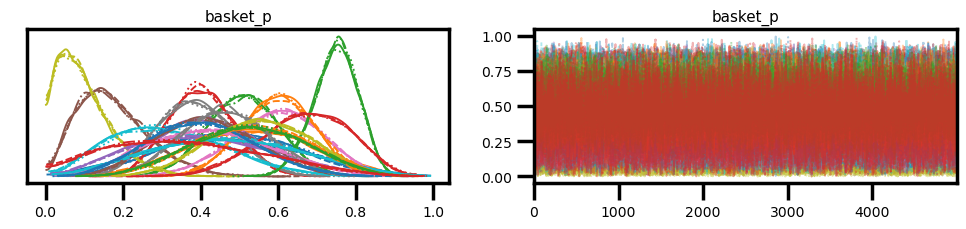

In [53]:
az.plot_trace(trace_s, var_names=['basket_p']);

array([<AxesSubplot: title={'center': '94.0% HDI'}>], dtype=object)

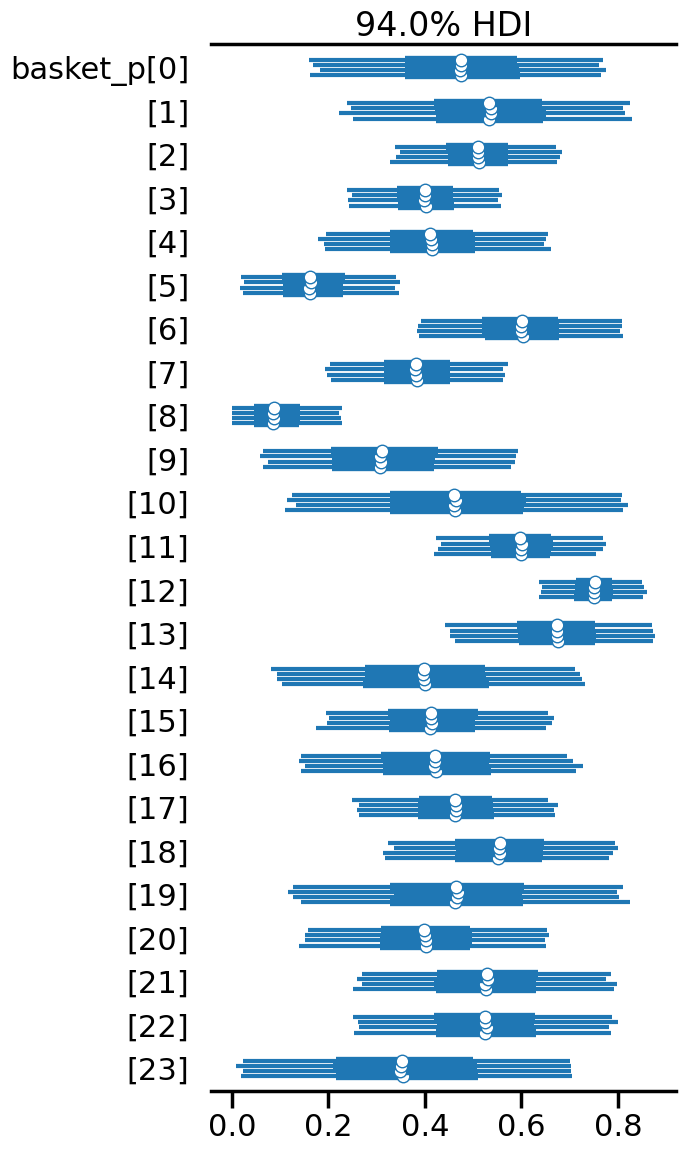

In [54]:
az.plot_forest(trace_s, var_names=['basket_p'])

In [55]:
stacked_s = az.extract(trace_s)

In [56]:
inferred_basket_s = np.mean(stacked_s.basket_p.values, axis=1)
inferred_basket_s.shape

(24,)

### BHM

In [57]:
p0 = 0.2
p1 = 0.4
model_h1 = get_model_bhm(pivot_df, p0, p1)

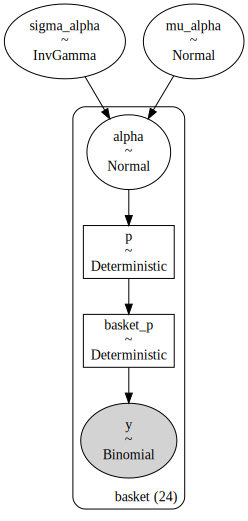

In [58]:
pm.model_to_graphviz(model_h1)

This is the one we actually use

In [59]:
model_h1 = get_model_bhm_nc(pivot_df, p0, p1)

In [60]:
with model_h1:
    trace_h1 = pm.sample(n_sample, tune=n_burn_in, idata_kwargs={'log_likelihood': True}, target_accept=target_accept)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [z_alpha, mu_alpha, sigma_alpha]


Sampling 4 chains for 5_000 tune and 5_000 draw iterations (20_000 + 20_000 draws total) took 62 seconds.


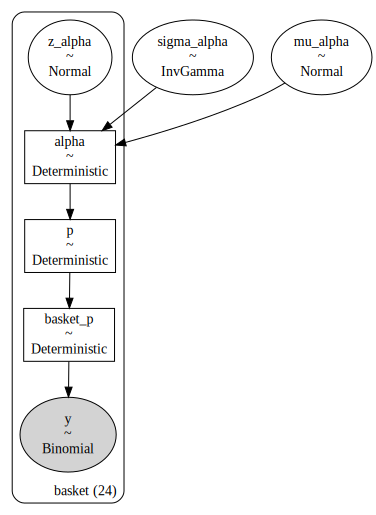

In [61]:
pm.model_to_graphviz(model_h1)

In [62]:
az.summary(trace_h1).round(2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
z_alpha[0],0.08,0.82,-1.45,1.62,0.0,0.01,34712.0,13456.0,1.0
z_alpha[1],0.32,0.78,-1.18,1.78,0.0,0.01,32154.0,14783.0,1.0
z_alpha[2],0.27,0.53,-0.76,1.24,0.0,0.00,20476.0,14836.0,1.0
z_alpha[3],-0.28,0.53,-1.32,0.70,0.0,0.00,19963.0,13021.0,1.0
z_alpha[4],-0.18,0.67,-1.46,1.07,0.0,0.00,28162.0,14765.0,1.0
...,...,...,...,...,...,...,...,...,...
basket_p[19],0.47,0.16,0.18,0.77,0.0,0.00,34966.0,15005.0,1.0
basket_p[20],0.42,0.12,0.18,0.64,0.0,0.00,38550.0,15742.0,1.0
basket_p[21],0.51,0.13,0.27,0.76,0.0,0.00,35943.0,14157.0,1.0
basket_p[22],0.51,0.13,0.27,0.75,0.0,0.00,34889.0,15041.0,1.0


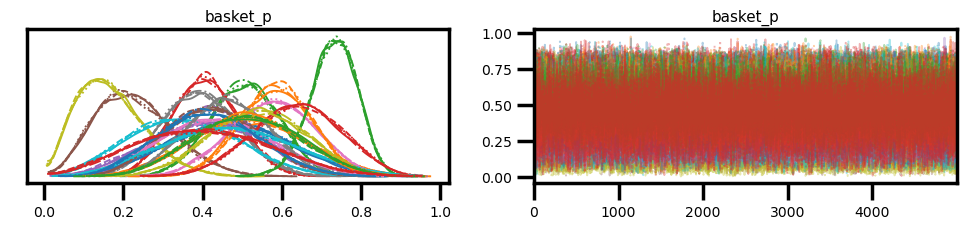

In [63]:
az.plot_trace(trace_h1, var_names=['basket_p']);

array([<AxesSubplot: title={'center': '94.0% HDI'}>], dtype=object)

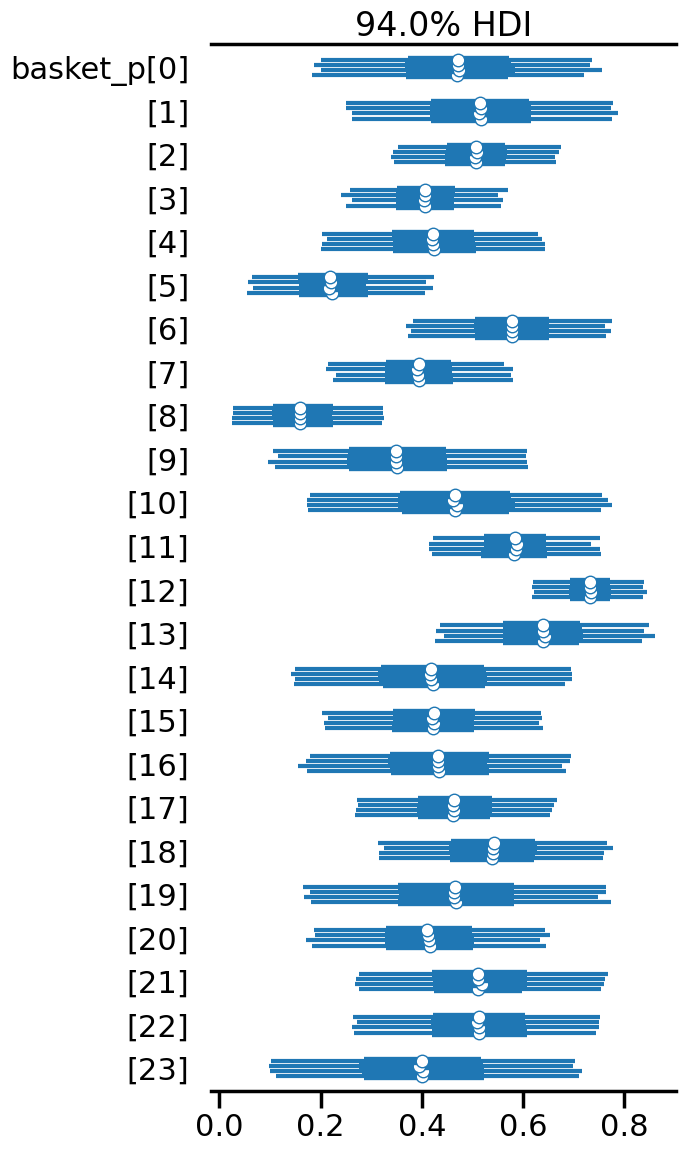

In [64]:
az.plot_forest(trace_h1, var_names=['basket_p'])

In [65]:
stacked_h1 = az.extract(trace_h1)

In [66]:
inferred_basket_h1 = np.mean(stacked_h1.basket_p.values, axis=1)
inferred_basket_h1.shape

(24,)

### pyBasket model

Another hierarchical model, but here we model the log-odds instead, so we can set Normal prior distributions on the parameters.

This is the model described in the paper, and it's what we shall use for further analysis.

In [68]:
model_h2 = get_model_pyBasket(patient_df)

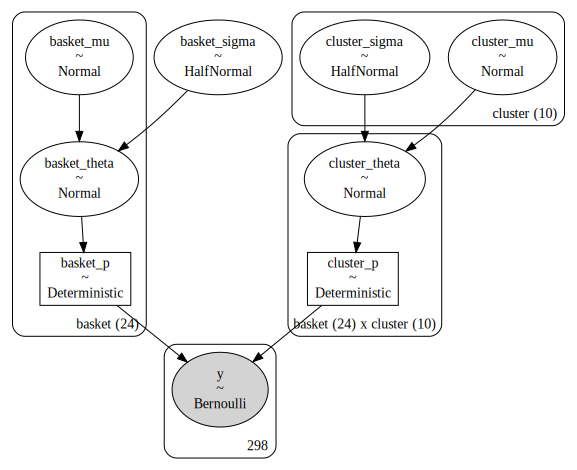

In [69]:
pm.model_to_graphviz(model_h2)

In [70]:
# with model_h2:
#     trace_h2 = pm.sample(n_sample, tune=n_burn_in, idata_kwargs={'log_likelihood': True})

This is the one we actually use after reparameterisation.

In [74]:
model_h2_nc = get_model_pyBasket_nc(patient_df)

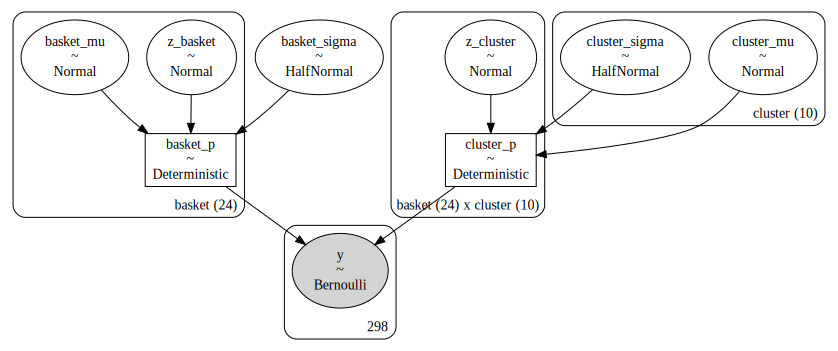

In [75]:
pm.model_to_graphviz(model_h2_nc)

In [77]:
with model_h2_nc:
    trace_h2 = pm.sample(n_sample, tune=n_burn_in, idata_kwargs={'log_likelihood': True}, target_accept=target_accept)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [z_basket, z_cluster, basket_mu, cluster_mu, basket_sigma, cluster_sigma]


Sampling 4 chains for 5_000 tune and 5_000 draw iterations (20_000 + 20_000 draws total) took 212 seconds.


In [78]:
az.summary(trace_h2).round(2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
z_basket[Biliary Tract],0.16,0.98,-1.67,2.04,0.01,0.01,27676.0,14994.0,1.0
z_basket[Bladder/Urinary Tract],0.20,0.98,-1.62,2.06,0.01,0.01,29525.0,15062.0,1.0
z_basket[Bone],0.13,0.98,-1.71,2.00,0.01,0.01,22989.0,15660.0,1.0
z_basket[Bowel],0.13,0.97,-1.71,1.96,0.01,0.01,23216.0,15647.0,1.0
z_basket[Breast],0.08,0.98,-1.77,1.89,0.01,0.01,27560.0,15949.0,1.0
...,...,...,...,...,...,...,...,...,...
"cluster_p[Uterus, 7]",0.71,0.23,0.29,1.00,0.00,0.00,16682.0,13576.0,1.0
"cluster_p[Uterus, 9]",0.69,0.23,0.26,1.00,0.00,0.00,17407.0,14318.0,1.0
"cluster_p[Uterus, 5]",0.73,0.21,0.34,1.00,0.00,0.00,18651.0,14498.0,1.0
"cluster_p[Uterus, 8]",0.77,0.19,0.40,1.00,0.00,0.00,17247.0,14635.0,1.0


In [79]:
# az.plot_ess(
#     trace_h2, kind="evolution", var_names=['basket_p', 'cluster_p']
# )

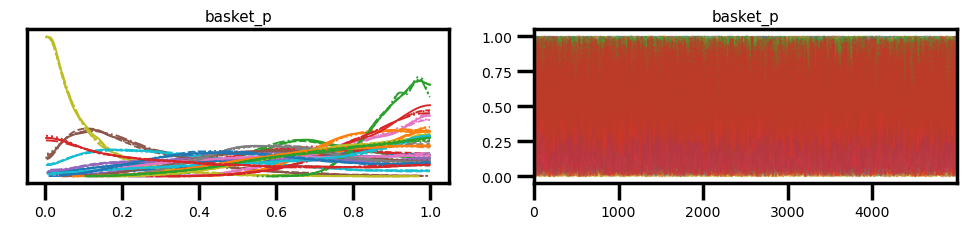

In [80]:
az.plot_trace(trace_h2, var_names=['basket_p']);

array([<AxesSubplot: title={'center': '94.0% HDI'}>], dtype=object)

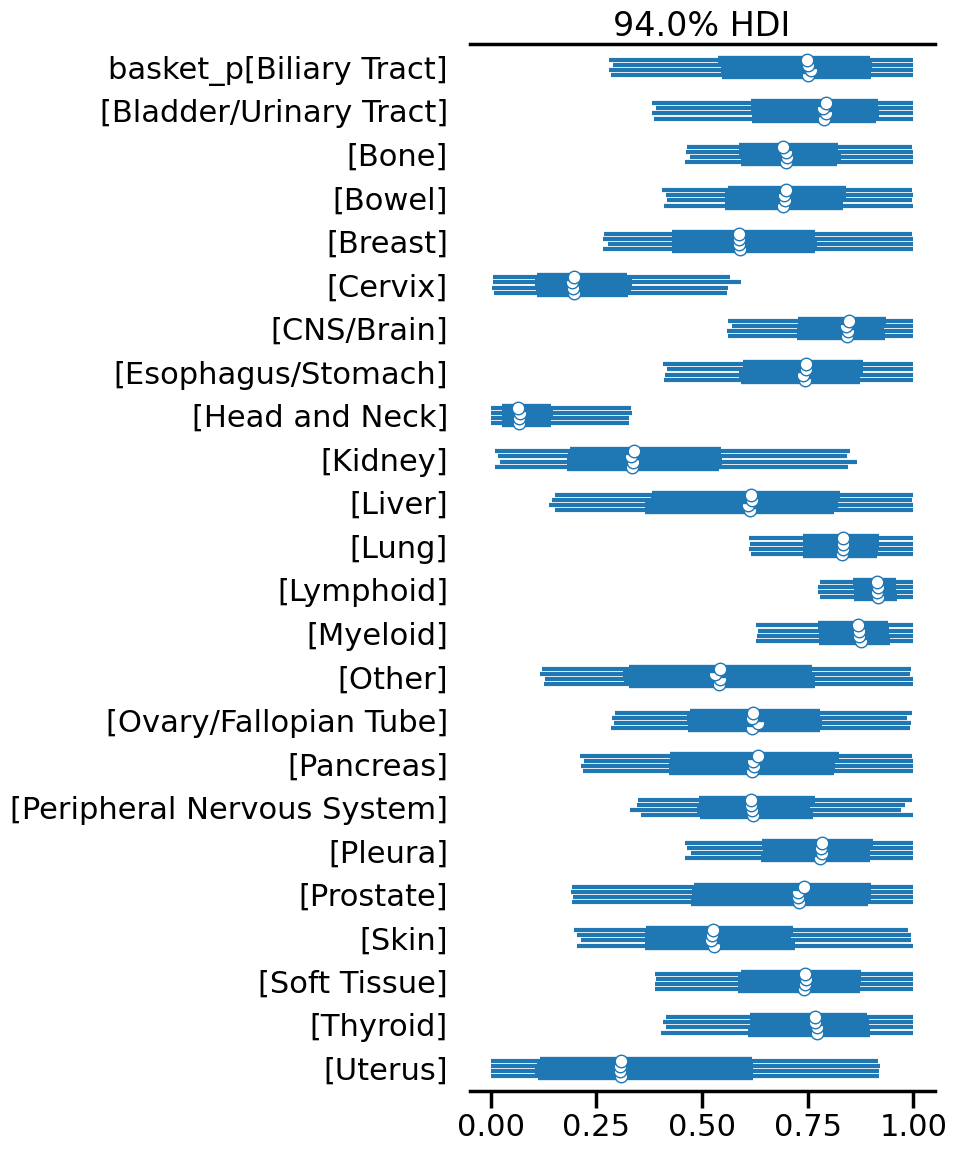

In [81]:
az.plot_forest(trace_h2, var_names=['basket_p'])

In [82]:
stacked_h2 = az.extract(trace_h2)

In [83]:
inferred_basket_h2 = np.mean(stacked_h2.basket_p.values, axis=1)
inferred_basket_h2.shape

(24,)

In [84]:
inferred_cluster_h2 = np.mean(stacked_h2.cluster_p.values, axis=2)
inferred_cluster_h2.shape

(24, 10)

In [85]:
inferred_basket_h2_tiled = np.tile(inferred_basket_h2, (C, 1)).T
inferred_mat_h2 = inferred_basket_h2_tiled * inferred_cluster_h2
inferred_mat_h2.shape

(24, 10)

## Compare the matrices

In [86]:
sns.set_context('poster')

In [87]:
predicted_basket_s_df = pd.DataFrame({'prob': inferred_basket_s, 'basket': range(len(inferred_basket_s))})
predicted_basket_h1_df = pd.DataFrame({'prob': inferred_basket_h1, 'basket': range(len(inferred_basket_h1))})
predicted_basket_h2_df = pd.DataFrame({'prob': inferred_basket_h2, 'basket': range(len(inferred_basket_h2))})

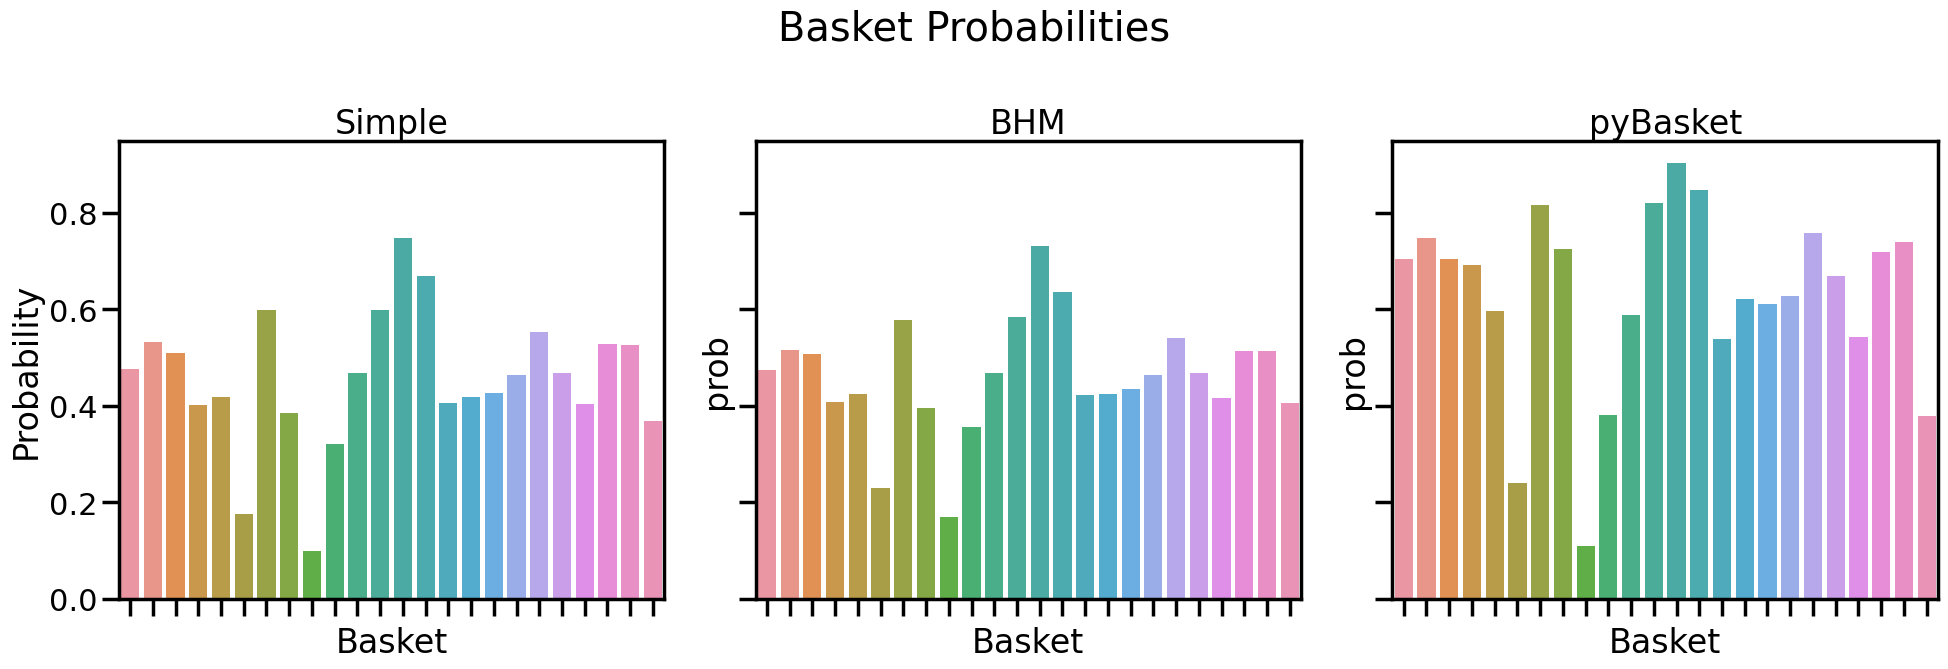

In [88]:
fig, ax = plt.subplots(1, 3, figsize=(20, 7), sharex=True, sharey=True)

sns.barplot(data=predicted_basket_s_df, x='basket', y='prob', ax=ax[0])
ax[0].set_title('Simple')
ax[0].set_xlabel('Basket')
ax[0].set_ylabel('Probability')
ax[0].set_xticklabels([])

sns.barplot(data=predicted_basket_h1_df, x='basket', y='prob', ax=ax[1])
ax[1].set_title('BHM')
ax[1].set_xlabel('Basket')
ax[1].set_xticklabels([])

sns.barplot(data=predicted_basket_h2_df, x='basket', y='prob', ax=ax[2])
ax[2].set_title('pyBasket')
ax[2].set_xlabel('Basket')
ax[2].set_xticklabels([])

plt.suptitle('Basket Probabilities')
plt.tight_layout()
plt.savefig('results/report_%s_%d_basket_probs.png' % (drug_name, C), dpi=300)

Text(6.4166666666666625, 0.5, 'Baskets')

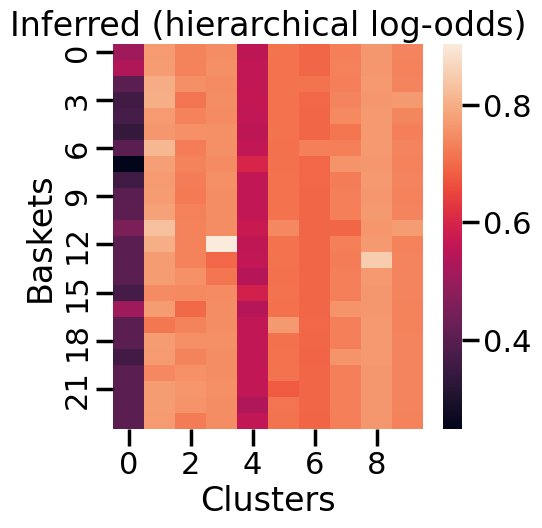

In [89]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5), sharex=True, sharey=True)
        
sns.heatmap(inferred_cluster_h2, ax=ax)
ax.set_title('Inferred (hierarchical log-odds)')
ax.set_xlabel('Clusters')
ax.set_ylabel('Baskets')

Text(6.4166666666666625, 0.5, 'Baskets')

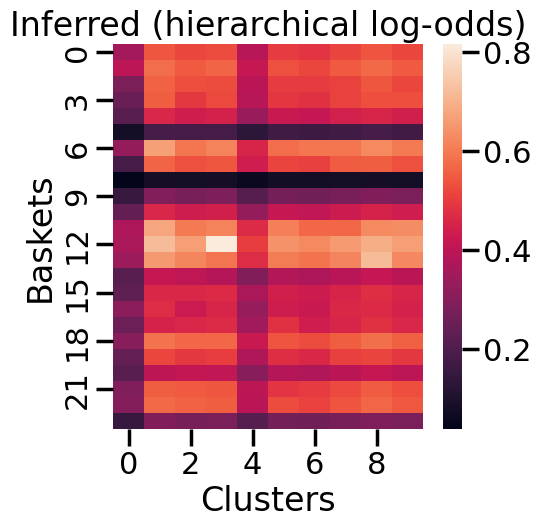

In [90]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5), sharex=True, sharey=True)
        
sns.heatmap(inferred_mat_h2, ax=ax)
ax.set_title('Inferred (hierarchical log-odds)')
ax.set_xlabel('Clusters')
ax.set_ylabel('Baskets')